# Get SBert Embedding

In [1]:
import os
import json
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize the Sentence-BERT model for embedding generation
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load the schema to get the list of all possible slot names
with open('./train/schema.json', 'r') as schema_file:
    schema_data = json.load(schema_file)

# Extract all unique slot names from the schema and sort them
all_slots = sorted({slot['name'] for service in schema_data for slot in service['slots']})

# Initialize the MultiLabelBinarizer with the unique slot names
mlb = MultiLabelBinarizer(classes=all_slots)
mlb.fit([all_slots])  # Fit the binarizer with the slot names

# Directory containing the dialogue files
dialogue_dir = './train'  # Replace with the actual path to the dialogue files
# List all files in the directory and filter for those that start with 'dialogues_' and end with '.json'
files = [filename for filename in os.listdir(dialogue_dir) if filename.startswith('dialogues_') and filename.endswith('.json')]

# Sort the files list to ensure sequential processing
files.sort()

# Initialize a list to hold paired descriptions for all dialogues
all_paired_descriptions = []

# Initialize a dictionary to count occurrences of each slot across filtered sentences
slot_counts = {slot: 0 for slot in all_slots}

# Iterate over each file in the dialogue directory
for filename in files:
    if filename.startswith('dialogues_') and filename.endswith('.json'):
        file_path = os.path.join(dialogue_dir, filename)
        
        # Load and process the current dialogue file
        with open(file_path, 'r') as dialogue_file:
            dialogues = json.load(dialogue_file)
        
        # Process each dialogue and each turn within
        for dialogue in dialogues:
            dialogue_id = dialogue['dialogue_id']
            for turn in dialogue['turns']:
                # Only process user turns
                if turn['speaker'] == 'USER':
                    user_text = turn['utterance']
                    
                    # Collect slots used in this turn
                    slots_present = [slot['slot'] for frame in turn.get("frames", []) for slot in frame.get("slots", [])]
                    
                    # Skip this turn if it has fewer than 3 slots
                    if len(slots_present) < 3:
                        continue
                    
                    # Update slot counts for slots in this turn
                    for slot in slots_present:
                        slot_counts[slot] += 1
                    
                    # Generate the text embedding for the user's dialogue
                    user_embedding = model.encode(user_text)
                    
                    # Create a binary slot matrix for this turn
                    binary_slot_matrix = mlb.transform([slots_present])[0]
                    
                    # Append this turn's data to the list
                    all_paired_descriptions.append({
                        'dialogue_id': dialogue_id,
                        'turn_id': turn.get('turn_id', None),
                        'user_text': user_text,
                        'user_embedding': user_embedding,
                        'slots_present': slots_present,
                        'binary_slot_matrix': binary_slot_matrix
                    })

# Filter out slots that never appeared in the selected sentences and sort them
filtered_slots = sorted([slot for slot, count in slot_counts.items() if count > 0])

# Update the MultiLabelBinarizer to only include the filtered slots
mlb_filtered = MultiLabelBinarizer(classes=filtered_slots)
mlb_filtered.fit([filtered_slots])

# Re-process each entry to create a binary slot matrix with only filtered slots
for item in all_paired_descriptions:
    item['binary_slot_matrix'] = mlb_filtered.transform([item['slots_present']])[0]

# Convert the aggregated list to a DataFrame
df = pd.DataFrame(all_paired_descriptions)

# Separate the texts into a list
texts = [item['user_text'] for item in all_paired_descriptions]

# Save the DataFrame and texts
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# Save DataFrame as CSV
df.to_csv(os.path.join(output_dir, 'dialogue_data.csv'), index=False)

# Save texts as a TXT file
text_file_path = os.path.join(output_dir, 'user_texts.txt')
with open(text_file_path, 'w') as text_file:
    for text in texts:
        text_file.write(text + '\n')

print(f"DataFrame saved to {os.path.join(output_dir, 'dialogue_data.csv')}")
print(f"User texts saved to {text_file_path}")
df['binary_slot_matrix'][2457]

/home/pa21701/medinfluencers-main/myenv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


DataFrame saved to ./output/dialogue_data.csv
User texts saved to ./output/user_texts.txt


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0])

In [1]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file
file_path = './output/dialogue_data.csv'
data = pd.read_csv(file_path)

# Function to add commas between numbers in string representations of lists
def fix_format(matrix_str):
    return '[' + ','.join(matrix_str.strip('[]').split()) + ']'

boolean_embedding = np.array([ast.literal_eval(fix_format(matrix)) for matrix in data['binary_slot_matrix']])
sentence_embeddings_bert = np.array([ast.literal_eval(fix_format(matrix)) for matrix in data['user_embedding']])
# Display shapes to verify successful extraction

print("Boolean Embedding Shape:", boolean_embedding.shape)

Boolean Embedding Shape: (2458, 47)


# Get GPT Embedding

In [2]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file
file_path = './paired_descriptions_sentence_gpt.csv'
data = pd.read_csv(file_path)

# Function to add commas between numbers in string representations of lists
def fix_format(matrix_str):
    return '[' + ','.join(matrix_str.strip('[]').split()) + ']'

# Apply fix_format to both 'user_embedding' and 'binary_slot_matrix' columns
sentence_embeddings_gpt = np.load('./gpt_embeddings.npy')
boolean_embedding = np.array([ast.literal_eval(fix_format(matrix)) for matrix in data['binary_slot_matrix']])
# Display shapes to verify successful extraction
print("GPT Sentence Embeddings Shape:", sentence_embeddings_gpt.shape)
print("Boolean Embedding Shape:", boolean_embedding.shape)

GPT Sentence Embeddings Shape: (2458, 1536)
Boolean Embedding Shape: (2458, 47)


# CCA: Pair all sentences with their embeddings

/home/pa21701/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/pa21701/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113

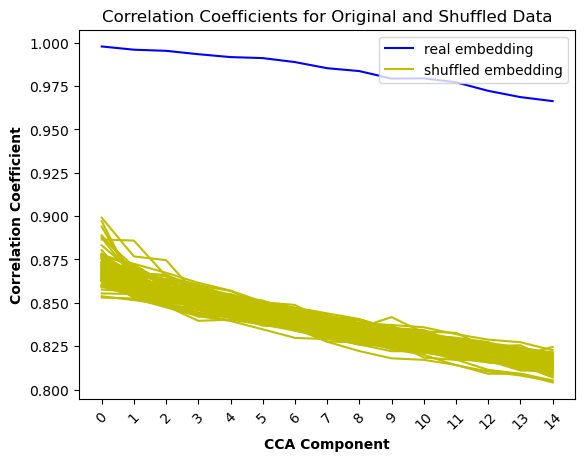

In [3]:
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

    
def plot_cca(X, Y):
    # num of components
#     n_comps = min(X.shape[1], Y.shape[1])
    n_comps = 15
    cca = CCA(n_components=n_comps)
    cca.fit(X, Y)
    X_c1, Y_c1 = cca.transform(X, Y)
    corrs1 = [np.corrcoef(X_c1[:, i], Y_c1[:, i])[0, 1] for i in range(n_comps)] 
    plt.plot(corrs1,'-b',label='real embedding')
    i=0
    while i < 100:
        Y_shuffled = shuffle(Y)
        cca1 = CCA(n_components=n_comps)
        cca1.fit(X, Y_shuffled)
        X_c2, Y_c2 = cca1.transform(X, Y_shuffled)  
        corrs2 = [np.corrcoef(X_c2[:, i], Y_c2[:, i])[0, 1] for i in range(n_comps)]
        i +=1
        plt.plot(corrs2, '-y')
        
    plt.xticks(np.arange(n_comps))
    plt.plot(corrs2, '-y',label='shuffled embedding')
    plt.xticks(np.arange(n_comps), rotation=45)
    plt.xlabel('CCA Component', fontweight='bold')
    plt.ylabel('Correlation Coefficient', fontweight='bold')
    plt.title('Correlation Coefficients for Original and Shuffled Data')
    plt.legend(loc="upper right")
    plt.savefig('permuted_sentence_CCA_gpt.png')
    plt.show()
    
plot_cca(boolean_embedding, sentence_embeddings_gpt)

# Get Llama Embedding

In [10]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file
file_path = './paired_descriptions_sentence_llama.csv'
data = pd.read_csv(file_path)

# Function to add commas between numbers in string representations of lists
def fix_format(matrix_str):
    return '[' + ','.join(matrix_str.strip('[]').split()) + ']'

# Apply fix_format to both 'user_embedding' and 'binary_slot_matrix' columns
sentence_embeddings_llama = np.load('./llama_embeddings.npy')
boolean_embedding = np.array([ast.literal_eval(fix_format(matrix)) for matrix in data['binary_slot_matrix']])
# Display shapes to verify successful extraction
print("Sentence Embeddings Shape:", sentence_embeddings_llama.shape)
print("Boolean Embedding Shape:", boolean_embedding.shape)

Sentence Embeddings Shape: (2458, 4096)
Boolean Embedding Shape: (2458, 47)


# Layer-wise Bert Embedding

In [49]:
import os
import pickle
import logging
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

# Set up logging
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)

# File paths and model configuration
path = './output/user_texts.txt'
out_path = './'
model_name = 'sentence-transformers/all-MiniLM-L6-v2'  # Full Hugging Face model path

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the SentenceTransformer model and move it to the device
sentence_model = SentenceTransformer(model_name)
sentence_model.to(device)

# Access the transformer model and the pooling layer
transformer_model = sentence_model[0].auto_model  # The transformer model
pooling_layer = sentence_model[1]  # The pooling layer

# Ensure the transformer model outputs hidden states
transformer_model.config.output_hidden_states = True

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

if __name__ == '__main__':
    # Read the input sentences and remove empty lines
    with open(path, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]

    print(f"Total sentences to process: {len(sentences)}")

    # Tokenize the sentences and move inputs to the correct device
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get the hidden states from the transformer model
    with torch.no_grad():
        outputs = transformer_model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of (num_layers+1 x batch_size x seq_len x hidden_dim)

    # Create the save directory
    save_path = os.path.join(out_path, 'embeddings/')
    os.makedirs(save_path, exist_ok=True)

    # Process each layer's embeddings using the pooling layer
    for layer_index, layer_embeddings in enumerate(hidden_states):
        print(f"Processing layer {layer_index}/{len(hidden_states)-1}")

        # Prepare inputs for pooling
        pooling_input = {
            'token_embeddings': layer_embeddings,      # Shape: [batch_size, seq_len, hidden_dim]
            'attention_mask': inputs['attention_mask']  # Shape: [batch_size, seq_len]
        }

        # Apply the pooling layer to get sentence embeddings
        with torch.no_grad():
            pooling_output = pooling_layer(pooling_input)

        embeddings = pooling_output['sentence_embedding']  # Shape: [batch_size, hidden_dim]

        # Apply L2 normalization to match SentenceTransformer's default behavior
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

        # Convert embeddings to numpy array
        embeddings_np = embeddings.detach().cpu().numpy()  # Shape: (batch_size, hidden_dim)

        # Save the layer's sentence embeddings and sentences together
        file_path = os.path.join(save_path, f"layer_{layer_index}_sentence_embeddings.npz")
        np.savez(file_path, embeddings=embeddings_np, sentences=sentences)
        logging.info(f'{file_path} saved.')

    print("Sentence embeddings saved layer by layer.")


2024-11-20 01:00:38 - Use pytorch device_name: cuda
2024-11-20 01:00:38 - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Using device: cuda
Total sentences to process: 2458
Processing layer 0/6


2024-11-20 01:00:40 - ./embeddings/layer_0_sentence_embeddings.npz saved.
2024-11-20 01:00:40 - ./embeddings/layer_1_sentence_embeddings.npz saved.
2024-11-20 01:00:40 - ./embeddings/layer_2_sentence_embeddings.npz saved.
2024-11-20 01:00:40 - ./embeddings/layer_3_sentence_embeddings.npz saved.
2024-11-20 01:00:40 - ./embeddings/layer_4_sentence_embeddings.npz saved.
2024-11-20 01:00:40 - ./embeddings/layer_5_sentence_embeddings.npz saved.
2024-11-20 01:00:40 - ./embeddings/layer_6_sentence_embeddings.npz saved.


Processing layer 1/6
Processing layer 2/6
Processing layer 3/6
Processing layer 4/6
Processing layer 5/6
Processing layer 6/6
Sentence embeddings saved layer by layer.


In [1]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file
file_path = './output/dialogue_data.csv'
data = pd.read_csv(file_path)

# Function to add commas between numbers in string representations of lists
def fix_format(matrix_str):
    return '[' + ','.join(matrix_str.strip('[]').split()) + ']'

boolean_embedding = np.array([ast.literal_eval(fix_format(matrix)) for matrix in data['binary_slot_matrix']])
# Display shapes to verify successful extraction

print("Boolean Embedding Shape:", boolean_embedding.shape)

Boolean Embedding Shape: (2458, 47)


In [2]:
# # Find all rows that have duplicate 'user_text' values
# duplicate_rows = data[data.duplicated(subset=['user_text'], keep=False)]

# # Display the duplicate rows
# print("Duplicate rows based on 'user_text' column:")
# print(duplicate_rows)

In [57]:
import numpy as np

layer_index = 6  # Specify the layer you want to load
embedding_file = f'./embeddings/layer_{layer_index}_sentence_embeddings.npz'
sentence_data = np.load(embedding_file, allow_pickle=True)

sentence_embeddings = sentence_data['embeddings']  # Shape: (batch_size, hidden_dim)
sentences = sentence_data['sentences']    # List of sentences

print(f"Number of sentences: {len(sentences)}")
print(f"Number of embeddings: {sentence_embeddings.shape[0]}")


Number of sentences: 2458
Number of embeddings: 2458


In [58]:
sentence_embeddings.shape

(2458, 384)

In [59]:
# Convert slots_present lists to tuples (after evaluating the string representations to lists)
data['slots_combination'] = data['slots_present'].apply(lambda x: tuple(sorted(ast.literal_eval(x))))

# Count unique combinations in the slots_combination column
unique_combinations = data['slots_combination'].nunique()
unique_combination_values = data['slots_combination'].unique()

# Output the results
print(f"Number of unique slot combinations: {unique_combinations}")
print("Unique slot combinations:", unique_combination_values)

Number of unique slot combinations: 90
Unique slot combinations: [('city', 'restaurant_name', 'time') ('date', 'restaurant_name', 'time')
 ('city', 'date', 'restaurant_name', 'time') ('city', 'date', 'time')
 ('city', 'date', 'restaurant_name') ('category', 'city', 'date')
 ('city_of_event', 'date', 'subcategory')
 ('genre', 'location', 'theater_name')
 ('movie_name', 'show_date', 'theater_name')
 ('city_of_event', 'date', 'event_name') ('city', 'date', 'event_name')
 ('departure_date', 'destination_city', 'origin_city')
 ('departure_date', 'destination', 'origin')
 ('departure_date', 'origin_city', 'return_date')
 ('departure_date', 'destination_city', 'return_date')
 ('destination_city', 'origin_city', 'return_date')
 ('departure_date', 'destination_city', 'origin_city', 'return_date')
 ('destination', 'origin', 'return_date')
 ('departure_date', 'origin', 'return_date')
 ('departure_date', 'destination', 'origin', 'return_date')
 ('departure_date', 'destination_city', 'outbound_depa

# LOO: Group by unique slot combinations and count occurrences

In [60]:
# Group by unique slot combinations and count occurrences
grouped_df = data.groupby('slots_combination').size().reset_index(name='count')

In [61]:
import pandas as pd
import numpy as np

# Step 1: Convert boolean_embedding arrays to tuples for grouping
boolean_embedding_tuples = [tuple(row) for row in boolean_embedding]

# Step 2: Create a DataFrame to associate each sentence embedding with its group identifier
df = pd.DataFrame({
    'group_id': boolean_embedding_tuples,  # Use tuples as group identifiers
    'embedding': list(sentence_embeddings) # Store each sentence embedding
})

# Step 3: Group by 'group_id' and compute the mean embedding for each group
grouped = df.groupby('group_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))

# Step 4: Extract the results into two separate matrices
group_boolean_embedding = np.array(grouped.index.tolist())  # Matrix of unique group identifiers
group_embeddings = np.vstack(grouped.values)               # Matrix of mean embeddings for each group

# Output the shapes to verify
print("group_boolean_embedding Shape:", group_boolean_embedding.shape)
print("group_embeddings Shape:", group_embeddings.shape)


group_boolean_embedding Shape: (90, 47)
group_embeddings Shape: (90, 384)


# L2 Norm

In [62]:
user_embedding = group_embeddings
user_boolean_embedding = group_boolean_embedding
attribute_embedding = np.linalg.pinv(user_boolean_embedding).dot(user_embedding)

In [63]:
B = np.dot(user_boolean_embedding, attribute_embedding)
np.random.seed(2)

In [64]:
from sklearn.utils import shuffle
from numpy.linalg import norm
i = 0
r_norm = []
while i < 100:
    user_embedding_shuffled = shuffle(user_embedding)
    attribute_embedding_shuffled = np.linalg.pinv(user_boolean_embedding).dot(user_embedding_shuffled)
    B_shuffled = np.dot(user_boolean_embedding, attribute_embedding_shuffled)
    r_norm.append(norm(B_shuffled - user_embedding_shuffled))
    i = i+1
r_norm

[3.9555886462252836,
 3.9815234306941094,
 3.9252001305416186,
 3.8584866303198657,
 4.131704319649379,
 3.860233034276107,
 4.063702222731541,
 3.9857647654108805,
 4.231264985380624,
 3.9844129763234455,
 3.951977716751998,
 3.962304848708108,
 4.020780240607167,
 4.044572471843389,
 3.937763856155047,
 3.8849112940292243,
 3.9322937460026477,
 3.9257551428680935,
 4.076468296092498,
 4.062905711283788,
 4.151094175110152,
 4.015989599878853,
 4.056452500884207,
 4.1027307504670345,
 4.039615010945738,
 3.900387236985863,
 4.113690040393837,
 4.129221770781261,
 3.914902563677154,
 4.041662273213488,
 4.042026912160844,
 4.180430822978602,
 3.9727038611359067,
 3.9010008125724918,
 3.9858137974050716,
 3.7613961123782502,
 3.853616011459895,
 3.935992905338809,
 4.0795032485114175,
 3.9325493426150055,
 3.975644925412279,
 3.933290616396856,
 3.8233424218190093,
 4.042599260760346,
 3.8362034358961252,
 3.861140598120574,
 3.8551237819079036,
 4.126199920555095,
 3.9021769573258145,


In [65]:
real_norm = norm(B - user_embedding)
real_norm

2.8390082923866418

# Cosine similarity

In [13]:
user_embedding = group_embeddings
user_boolean_embedding = group_boolean_embedding
np.random.seed(2)

In [14]:
import numpy as np
from sklearn.utils import shuffle

def leave_one_out_cosine(user_embedding, user_boolean_embedding, num_experiments=100, num_permutations=100):
    """
    Perform leave-one-out experiments to compute cosine similarities between predicted and actual embeddings.
    
    Parameters:
    - user_embedding: np.ndarray
        The embedding matrix of users.
    - user_boolean_embedding: np.ndarray
        The boolean indicator matrix for user attributes.
    - num_experiments: int, optional (default=100)
        Number of experiments to run in each permutation.
    - num_permutations: int, optional (default=100)
        Number of permutations (shuffles) to perform.
        
    Returns:
    - mean_real_similarity: float
        The mean cosine similarity from the real (unshuffled) data.
    - cosine_similarities: list of floats
        The mean cosine similarities from each permutation.
    """
    num_users = user_embedding.shape[0]
    real_similarities = []
    
    # Real data experiments (without shuffling)
    for _ in range(num_experiments):
        # Select a random user to remove
        removed_user_index = np.random.randint(num_users)
        
        # Remove the selected user from both matrices
        user_embedding1 = np.delete(user_embedding, removed_user_index, axis=0)
        user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)
        
        # Compute the attribute_embedding using the remaining users
        attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)
        
        # Compute the predicted embedding for the removed user
        removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)
        
        # Compute the similarity between the predicted embedding and the real embedding
        real_user_embedding = user_embedding[removed_user_index]
        similarity = np.dot(removed_user, real_user_embedding) / (np.linalg.norm(removed_user) * np.linalg.norm(real_user_embedding))
        similarity = np.clip(similarity, -1, 1)
        real_similarities.append(similarity)
    
    mean_real_similarity = np.mean(real_similarities)
    print("Mean similarity with real embeddings:", mean_real_similarity)
    
    # Permuted data experiments
    cosine_similarities = []
    sum1 = 0
    for _ in range(num_permutations):
        mean_for_1 = []
        for _ in range(num_experiments):
            # Shuffle the user embeddings
            shuffled_embedding = shuffle(user_embedding, random_state=None)
            
            # Select a random user index to remove
            removed_user_index = np.random.randint(num_users)
            
            # Remove the selected user from both matrices
            user_embedding1 = np.delete(shuffled_embedding, removed_user_index, axis=0)
            user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)
            
            # Compute the attribute_embedding using the remaining users
            attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)
            
            # Compute the predicted embedding for the removed user
            removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)
            real_user_embedding = shuffled_embedding[removed_user_index]
            
            # Compute the similarity
            permuted_cosine_similarity = np.dot(removed_user, real_user_embedding) / (np.linalg.norm(removed_user) * np.linalg.norm(real_user_embedding))
            permuted_cosine_similarity = np.clip(permuted_cosine_similarity, -1, 1)
            mean_for_1.append(permuted_cosine_similarity)
        
        # Count how many permuted similarities exceed the real mean similarity
        count = sum(1 for x in mean_for_1 if x > mean_real_similarity)
        sum1 += count
        
        # Append the mean similarity of this permutation
        cosine_similarities.append(np.mean(mean_for_1))
    
    # Print the mean similarity from permuted embeddings
    print("Mean similarity with permuted embeddings:", np.mean(cosine_similarities))
    
    return mean_real_similarity, cosine_similarities


In [15]:
# Assuming you have your user_embedding and user_boolean_embedding defined
mean_real_similarity, cosine_similarities = leave_one_out_cosine(
    user_embedding=group_embeddings,
    user_boolean_embedding=group_boolean_embedding,
    num_experiments=100,
    num_permutations=100
)


Mean similarity with real embeddings: 0.7761361450996082
Mean similarity with permuted embeddings: 0.4865256543145181


In [16]:
cosine_similarities

[0.4752837175985878,
 0.48689410326113536,
 0.4957334463166469,
 0.47258472068287416,
 0.5086046897911883,
 0.4865921510061835,
 0.4999434149798981,
 0.5468915499478165,
 0.5077965674105878,
 0.5339364580228696,
 0.44315296070856003,
 0.49902353748182404,
 0.4975189333360523,
 0.48216880700013115,
 0.49902976439993485,
 0.5041905238029853,
 0.49502284453361006,
 0.46186877929328707,
 0.4463594666072692,
 0.49995559260692723,
 0.5338803537383294,
 0.45867398977104534,
 0.506546303084619,
 0.4525495375415362,
 0.5172146386335861,
 0.46664615465773174,
 0.4961487737119546,
 0.4504210740515392,
 0.5178582488788418,
 0.4411758315491688,
 0.5006390683989026,
 0.4635984329283412,
 0.4969124373450946,
 0.4739340059552095,
 0.4866910444006868,
 0.4665122219145,
 0.47183836948207797,
 0.512406530522435,
 0.4827575562237645,
 0.4642058182179652,
 0.4487315085205305,
 0.4673768452131421,
 0.487414384599852,
 0.5097983339739073,
 0.4718789495442153,
 0.4952652331258085,
 0.46282497064837896,
 0.495

In [14]:
min(cosine_similarities), max(cosine_similarities)

(0.4387680769183141, 0.5478879766383559)

In [15]:
Normalized_cosine_similarity = (mean_real_similarity-np.mean(cosine_similarities))/(1-np.mean(cosine_similarities))
print("Normalized_cosine_similarity: ", Normalized_cosine_similarity)

Normalized_cosine_similarity:  0.49671675312928215


In [16]:
mean_permuted_similarity = np.mean(cosine_similarities)
std_permuted_similarity = np.std(cosine_similarities)

# Calculate the Z-score
if std_permuted_similarity != 0:
    z_score_cosine = (mean_real_similarity - mean_permuted_similarity) / std_permuted_similarity
else:
    z_score_cosine = float('inf')  # Handle case where std is 0 to avoid division by zero

# Print the Z-score
print("Z-Score_cosine:", z_score_cosine)
print("Absolute Difference Cosine", mean_real_similarity - mean_permuted_similarity)
print("Relative Difference Cosine (Percentage Improvement)", mean_real_similarity/mean_permuted_similarity)

Z-Score_cosine: 11.0584883468703
Absolute Difference Cosine 0.2549391119932307
Relative Difference Cosine (Percentage Improvement) 1.5237561561107391


# Retrieval Accuracy

In [17]:
user_embedding = group_embeddings
user_boolean_embedding = group_boolean_embedding
np.random.seed(2)

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def leave_one_out_retrieval(user_embedding, user_boolean_embedding, num_trials=100, num_permutations=100):
    np.random.seed(2)
    """
    Perform leave-one-out retrieval experiments to compute hits@5 accuracy of predicting a user's embedding.

    Parameters:
    - user_embedding: np.ndarray
        The embedding matrix of users.
    - user_boolean_embedding: np.ndarray
        The boolean indicator matrix for user attributes.
    - num_trials: int, optional (default=100)
        Number of trials to run in each experiment.
    - num_permutations: int, optional (default=100)
        Number of permutations (shuffles) to perform in permuted experiments.

    Returns:
    - hits_at_5_real: float
        The hits@5 accuracy of retrieval on real embeddings.
    - hits_at_5_permuted: list of floats
        The hits@5 accuracies of retrieval on permuted embeddings for each permutation.
    """
    num_users = user_embedding.shape[0]

    # --- Real Data Experiment ---
    count_real_hits_5 = 0
    for _ in range(num_trials):
        # Select a random user index to remove
        removed_user_index = np.random.randint(num_users)

        # Remove the selected user from both matrices
        user_embedding1 = np.delete(user_embedding, removed_user_index, axis=0)
        user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)

        # Compute the attribute_embedding using the remaining users
        attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)

        # Compute the predicted embedding for the removed user
        removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)

        # Compute the cosine similarity between the predicted embedding and all user embeddings
        similarities = cosine_similarity(user_embedding, [removed_user]).flatten()

        # Get the indices of the top 5 most similar embeddings
        top_5_indices = np.argsort(-similarities)[:5]

        # Check if the removed user index is within the top 5
        if removed_user_index in top_5_indices:
            count_real_hits_5 += 1

    # Compute the hits@5 accuracy for real embeddings
    hits_at_5_real = count_real_hits_5 / num_trials
    print("Hits@5 accuracy with real embeddings:", hits_at_5_real)

    # --- Permuted Data Experiments ---
    hits_at_5_permuted = []
    for _ in range(num_permutations):
        count_permutation_hits_5 = 0
        # Shuffle the user embeddings
        shuffled_embedding = user_embedding.copy()
        np.random.shuffle(shuffled_embedding)

        for _ in range(num_trials):
            # Select a random user index to remove
            removed_user_index = np.random.randint(num_users)

            # Remove the selected user from both matrices
            user_embedding1 = np.delete(shuffled_embedding, removed_user_index, axis=0)
            user_boolean_embedding1 = np.delete(user_boolean_embedding, removed_user_index, axis=0)

            # Compute the attribute_embedding using the remaining users
            attribute_embedding = np.linalg.pinv(user_boolean_embedding1).dot(user_embedding1)

            # Compute the predicted embedding for the removed user
            removed_user = np.dot(user_boolean_embedding[removed_user_index], attribute_embedding)

            # Compute the cosine similarity between the predicted embedding and all user embeddings
            similarities = cosine_similarity(shuffled_embedding, [removed_user]).flatten()

            # Get the indices of the top 5 most similar embeddings
            top_5_indices = np.argsort(-similarities)[:5]

            # Check if the removed user index is within the top 5
            if removed_user_index in top_5_indices:
                count_permutation_hits_5 += 1

        # Compute hits@5 accuracy for this permutation
        hits_at_5_permutation = count_permutation_hits_5 / num_trials
        hits_at_5_permuted.append(hits_at_5_permutation)

    # Compute mean hits@5 accuracy for permuted embeddings
    mean_hits_at_5_permuted = np.mean(hits_at_5_permuted)
    print("Mean hits@5 accuracy with permuted embeddings:", mean_hits_at_5_permuted)

    return hits_at_5_real, hits_at_5_permuted


In [19]:
# Assuming you have your user_embedding and user_boolean_embedding defined
accuracy_real, accuracies_permuted = leave_one_out_retrieval(
    user_embedding=user_embedding,
    user_boolean_embedding=user_boolean_embedding,
    num_trials=100,
    num_permutations=100
)


Hits@5 accuracy with real embeddings: 0.59
Mean hits@5 accuracy with permuted embeddings: 0.04049999999999999


In [20]:
accuracies_permuted

[0.03,
 0.0,
 0.08,
 0.01,
 0.06,
 0.03,
 0.02,
 0.03,
 0.05,
 0.04,
 0.01,
 0.06,
 0.06,
 0.03,
 0.07,
 0.05,
 0.06,
 0.06,
 0.04,
 0.06,
 0.03,
 0.03,
 0.04,
 0.05,
 0.01,
 0.0,
 0.01,
 0.06,
 0.01,
 0.09,
 0.05,
 0.05,
 0.0,
 0.03,
 0.03,
 0.03,
 0.06,
 0.0,
 0.04,
 0.08,
 0.01,
 0.02,
 0.05,
 0.02,
 0.03,
 0.02,
 0.02,
 0.01,
 0.04,
 0.05,
 0.05,
 0.08,
 0.1,
 0.03,
 0.09,
 0.05,
 0.03,
 0.03,
 0.01,
 0.03,
 0.05,
 0.04,
 0.03,
 0.0,
 0.01,
 0.02,
 0.08,
 0.03,
 0.08,
 0.02,
 0.05,
 0.04,
 0.08,
 0.03,
 0.04,
 0.02,
 0.05,
 0.07,
 0.02,
 0.0,
 0.05,
 0.07,
 0.06,
 0.0,
 0.03,
 0.04,
 0.07,
 0.03,
 0.04,
 0.05,
 0.04,
 0.11,
 0.07,
 0.01,
 0.06,
 0.03,
 0.07,
 0.05,
 0.01,
 0.08]

In [20]:
min(accuracies_permuted), max(accuracies_permuted)

(0.0, 0.11)

In [34]:
Normalized_retrieval_accuracy = (accuracy_real-np.mean(accuracies_permuted))/(1-np.mean(accuracies_permuted))
print("Normalized_retrieval_accuracy: ", Normalized_retrieval_accuracy)

Normalized_retrieval_accuracy:  0.5518032103397956


In [13]:
import numpy as np
from sentence_transformers import SentenceTransformer

# Paths
embedding_file = './embeddings/layer_6_sentence_embeddings.npz'
input_sentences_file = './output/user_texts.txt'

# Load the layer 6 embeddings
data = np.load(embedding_file, allow_pickle=True)
layer6_embeddings = data['embeddings']  # Shape: (2458, hidden_dim)
sentences = data['sentences']  # List of sentences

# Load the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings using model.encode
encode_embeddings = model.encode(sentences, convert_to_numpy=True, batch_size=32, show_progress_bar=True)

# Verify the shapes
print(f"Layer 6 Embeddings Shape: {layer6_embeddings.shape}")
print(f"model.encode Embeddings Shape: {encode_embeddings.shape}")

# Compare the embeddings
# Compute the difference using L2 norm
difference = np.linalg.norm(layer6_embeddings - encode_embeddings, axis=1)

# Print statistics
print(f"Difference statistics:")
print(f"Max difference: {np.max(difference)}")
print(f"Min difference: {np.min(difference)}")
print(f"Mean difference: {np.mean(difference)}")
print(f"Standard deviation of difference: {np.std(difference)}")

# Optionally, print a few differences
for i in range(5):
    print(f"Sentence: {sentences[i]}")
    print(f"Layer 6 Embedding (first 5 dims): {layer6_embeddings[i][:5]}")
    print(f"model.encode Embedding (first 5 dims): {encode_embeddings[i][:5]}")
    print(f"Difference: {difference[i]}\n")


Batches:   0%|          | 0/77 [00:00<?, ?it/s]

Layer 6 Embeddings Shape: (2458, 384)
model.encode Embeddings Shape: (2458, 384)
Difference statistics:
Max difference: 9.409243375557708e-07
Min difference: 0.0
Mean difference: 5.493398589351273e-07
Standard deviation of difference: 2.6395898089504044e-07
Sentence: I want a reservation for Hisui in Vacaville at, say, quarter to 8 in the evening.
Layer 6 Embedding (first 5 dims): [ 0.05543156  0.04917853 -0.02953065 -0.00823469 -0.15241422]
model.encode Embedding (first 5 dims): [ 0.05543151  0.04917853 -0.02953066 -0.00823469 -0.15241416]
Difference: 6.549530553456862e-07

Sentence: Book a table for four at Kusakabe for later today. Make the reservation for evening 6:45.
Layer 6 Embedding (first 5 dims): [ 0.05162968  0.00665241 -0.06642075 -0.00949855 -0.08385101]
model.encode Embedding (first 5 dims): [ 0.05162975  0.00665246 -0.06642075 -0.00949853 -0.083851  ]
Difference: 7.14049178895948e-07

Sentence: I'd prefer the Lark restaurant in San Fran at five in the evening.
Layer 6 Em

In [14]:
import pandas as pd
import numpy as np

# Step 1: Convert boolean_embedding arrays to tuples for grouping
boolean_embedding_tuples = [tuple(row) for row in boolean_embedding]

# Step 2: Create a DataFrame to associate each sentence embedding with its group identifier
df = pd.DataFrame({
    'group_id': boolean_embedding_tuples,  # Use tuples as group identifiers
    'embedding': list(layer6_embeddings) # Store each sentence embedding
})

# Step 3: Group by 'group_id' and compute the mean embedding for each group
grouped = df.groupby('group_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))

# Step 4: Extract the results into two separate matrices
group_boolean_embedding = np.array(grouped.index.tolist())  # Matrix of unique group identifiers
group_layer6_embeddings = np.vstack(grouped.values)               # Matrix of mean embeddings for each group

# Output the shapes to verify
print("group_boolean_embedding Shape:", group_boolean_embedding.shape)
print("group_embeddings Shape:", group_layer6_embeddings.shape)


group_boolean_embedding Shape: (90, 47)
group_embeddings Shape: (90, 384)


In [15]:
import pandas as pd
import numpy as np

# Step 1: Convert boolean_embedding arrays to tuples for grouping
boolean_embedding_tuples = [tuple(row) for row in boolean_embedding]

# Step 2: Create a DataFrame to associate each sentence embedding with its group identifier
df = pd.DataFrame({
    'group_id': boolean_embedding_tuples,  # Use tuples as group identifiers
    'embedding': list(encode_embeddings) # Store each sentence embedding
})

# Step 3: Group by 'group_id' and compute the mean embedding for each group
grouped = df.groupby('group_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))

# Step 4: Extract the results into two separate matrices
group_boolean_embedding = np.array(grouped.index.tolist())  # Matrix of unique group identifiers
group_encoded_embeddings = np.vstack(grouped.values)               # Matrix of mean embeddings for each group

# Output the shapes to verify
print("group_boolean_embedding Shape:", group_boolean_embedding.shape)
print("group_embeddings Shape:", group_encoded_embeddings.shape)


group_boolean_embedding Shape: (90, 47)
group_embeddings Shape: (90, 384)


In [17]:
# Optionally, print a few differences
for i in range(5):
    print(f"Sentence: {sentences[i]}")
    print(f"Layer 6 group Embedding (first 5 dims): {group_layer6_embeddings[i][:5]}")
    print(f"model.encode group Embedding (first 5 dims): {group_encoded_embeddings[i][:5]}")
    print(f"Difference: {difference[i]}\n")

Sentence: I want a reservation for Hisui in Vacaville at, say, quarter to 8 in the evening.
Layer 6 group Embedding (first 5 dims): [ 0.01361922 -0.05974812 -0.01850906 -0.00444105 -0.00631948]
model.encode group Embedding (first 5 dims): [ 0.01361922 -0.05974814 -0.01850906 -0.00444106 -0.00631947]
Difference: 6.549530553456862e-07

Sentence: Book a table for four at Kusakabe for later today. Make the reservation for evening 6:45.
Layer 6 group Embedding (first 5 dims): [ 0.05527849 -0.03644583  0.0190756   0.01860229  0.03458186]
model.encode group Embedding (first 5 dims): [ 0.0552785  -0.03644583  0.01907563  0.01860228  0.03458186]
Difference: 7.14049178895948e-07

Sentence: I'd prefer the Lark restaurant in San Fran at five in the evening.
Layer 6 group Embedding (first 5 dims): [ 0.06181698 -0.05512951  0.02867316  0.03135552 -0.00579233]
model.encode group Embedding (first 5 dims): [ 0.06181699 -0.05512951  0.02867317  0.03135552 -0.00579234]
Difference: 5.664966238327906e-07

